Get results by criteria

In [4]:
flipped_list = ['250005-003','250005-004','250005-007','276004-001','348003-002','703001-018','703003-010']

In [1]:
import json
import os
import csv
import pandas as pd

df_disease = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload_disease = df_disease.loc[df_disease['Descriptor'] == 'Infarction_Ratio']

results_list = []
with open(r'Quorum_output_RV_removed\Baseline\temp_allClasses\summary.json', 'r') as fd_in:
    metric_file = json.load(fd_in)['results']['all']
    for data_dict in metric_file:
        name = data_dict['center']
        infraction_percent = payload_disease
        center = name.split('-')[0]
        manufacturer = data_dict['manufacturer']
        phase = data_dict['reference'].split('\\')[-1][11:13]

        if name in payload_disease:
            infraction_percent = payload_disease[name][0]
        else:
            infraction_percent = ''

        field_strength = str(data_dict['strength'])

        rv_dice = data_dict['1']['Dice']
        myo_dice = data_dict['2']['Dice']
        lv_dice = data_dict['3']['Dice']
        dice = (rv_dice + myo_dice + lv_dice) / 3

        rv_hd = data_dict['1']['Hausdorff Distance']
        myo_hd = data_dict['2']['Hausdorff Distance']
        lv_hd = data_dict['3']['Hausdorff Distance']
        hd = (rv_hd + myo_hd + lv_hd) / 3

        rv_assd = data_dict['1']['Avg. Symmetric Surface Distance']
        myo_assd = data_dict['2']['Avg. Symmetric Surface Distance']
        lv_assd = data_dict['3']['Avg. Symmetric Surface Distance']
        assd = (rv_assd + myo_assd + lv_assd) / 3

        results_list.append({'Name': name, 
                            'Center': center, 
                            'Manufacturer': manufacturer, 
                            'Phase': phase, 
                            'infraction_percent': infraction_percent,
                            'Field Strength': field_strength, 
                            'RV dice': rv_dice,
                            'MYO dice': myo_dice,
                            'LV dice': lv_dice,
                            'Mean dice': dice, 
                            'RV HD': rv_hd,
                            'MYO HD': myo_hd,
                            'LV HD': lv_hd,
                            'Mean HD': hd,
                            'RV_assd': rv_assd,
                            'MYO_assd': myo_assd,
                            'LV_assd': lv_assd,
                            'Mean assd': assd
                            })

with open(os.path.join('Quorum_output_RV_removed', 'Baseline', 'Criteria_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

In [23]:
import pickle
from glob import glob
import pandas as pd

with open(r'splits_final.pkl', 'rb') as fd:
    data = pickle.load(fd)
    train_names = data[0]['train']
    train_names = [x[:-3] for x in train_names]

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d

centers = {}
manufacturers = {}
strengths = {}
depths = {}
phases = {}
path_list = glob(r'custom_quorum\**\*.csv')
for path in path_list:
    df = pd.read_csv(path)
    filename = path.split('\\')[-1]
    patient_name = path.split('\\')[-2]
    phase = filename[:2]
    manufacturer = df['Manufacturer'].iloc[0]
    strength = df['Field Strength'].iloc[0]

    if patient_name in train_names:
        manufacturers = update_dict(manufacturers, str(manufacturer), filename)
        strengths = update_dict(strengths, str(strength), filename)
        phases = update_dict(phases, str(phase), filename)

for current_dict in [manufacturers, strengths, phases]:
    for k in current_dict.keys():
        print(f'{k} = {len(current_dict[k])}')

siemens = 248
philips = 14
ge = 48
1.5 = 280
3.0 = 30
ed = 155
es = 155


In [1]:
from glob import glob
import os
import json
import numpy as np
import yaml
import pandas as pd

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d

output_file_name = 'quorum_output_field.yaml'
if os.path.exists(output_file_name):
    os.remove(output_file_name)

centers = {}
manufacturers = {}
strengths = {}
depths = {}
phases = {}

path_list = glob(r'Quorum_output_2\only_sfb\fold_0\temp_allClasses\*.gz')
for path in path_list:
    filename = path.split('\\')[-1]
    phase = filename[11:13]
    name = filename.split('_')[0]
    df = pd.read_csv(os.path.join('custom_quorum_2', name, phase + '_info.csv'))
    center = df['Name'].iloc[0].split('-')[0]
    manufacturer = df['Manufacturer'].iloc[0]
    strength = df['Field Strength'].iloc[0]

    centers = update_dict(centers, str(center), filename)
    manufacturers = update_dict(manufacturers, str(manufacturer), filename)
    strengths = update_dict(strengths, str(strength), filename)
    phases = update_dict(phases, str(phase), filename)

with open(r'Quorum_output_2\only_sfb\fold_0\temp_allClasses\summary.json', 'r') as fd_in:
    metric_file = json.load(fd_in)['results']['all']
    results_dict = {}
    for current_dict, criteria_name in zip([centers, manufacturers, strengths, phases], ['Center', 'Manufacturer', 'Field Strength', 'Phase']):
        for key in current_dict.keys():
            print(f'{key} = {len(current_dict[key])}')
            current_values = current_dict[key]
            list_of_dict = [x for x in metric_file if x['reference'].split('/')[-1] in current_values]
            mean_dice_list = []
            mean_hausdorff_list = []
            for data_dict in list_of_dict:
                rv_dice = data_dict['1']['Dice']
                myo_dice = data_dict['2']['Dice']
                lv_dice = data_dict['3']['Dice']
                results_list.append({criteria_name: key, 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})
                mean_dice_list.append([data_dict['1']['Dice'], data_dict['2']['Dice'], data_dict['3']['Dice']])
                mean_hausdorff_list.append([data_dict['1']['Hausdorff Distance'], data_dict['2']['Hausdorff Distance'], data_dict['3']['Hausdorff Distance']])
            class_dice = np.stack(mean_dice_list, axis=0).mean(axis=0)
            class_hausdorff = np.stack(mean_hausdorff_list, axis=0).mean(axis=0)
            results_dict[key] = {'Hausdorff distance': class_hausdorff.tolist(), 
                                'Mean Hausdorff distance': float(class_hausdorff.mean()), 
                                'Dice score': class_dice.tolist(),
                                'Mean dice score': float(class_dice.mean())}

with open(output_file_name, 'w') as fd:
    yaml.safe_dump(results_dict, fd, default_flow_style=False)
    #for results_dict in results_dicts:
    #    for key in results_dict.keys():
    #        fd.write(key + ': ' + str(results_dict[key]) + '\n')
    #    fd.write('\n')


250001 = 10
250005 = 2
276004 = 2
276005 = 2
276008 = 2
348001 = 6
348002 = 6
348003 = 2
348004 = 8
348007 = 6
616003 = 4
616005 = 2
616010 = 2
703001 = 10
703003 = 2
703004 = 8
724002 = 2
724006 = 4
siemens = 62
philips = 4
ge = 14
1.5 = 66
3.0 = 14
ed = 40
es = 40


Get ED/ES volume

In [5]:
import nibabel as nib
import numpy as np

data = nib.load(r'quorum_output\validation_raw\patient003_ed.nii.gz')
zoom = data.header.get_zooms()
pixel_volume = np.prod(zoom)
print(pixel_volume)
arr = data.get_fdata()
nb_pixels = np.count_nonzero(arr == 1)
print(nb_pixels * pixel_volume)

13.234375
187504.625


In [1]:
%matplotlib qt

import nibabel as nib
import numpy as np
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

def bwperim(bw, n=4):
    """
    perim = bwperim(bw, n=4)
    Find the perimeter of objects in binary images.
    A pixel is part of an object perimeter if its value is one and there
    is at least one zero-valued pixel in its neighborhood.
    By default the neighborhood of a pixel is 4 nearest pixels, but
    if `n` is set to 8 the 8 nearest pixels will be considered.
    Parameters
    ----------
      bw : A black-and-white image
      n : Connectivity. Must be 4 or 8 (default: 8)
    Returns
    -------
      perim : A boolean image
    """

    if n not in (4,8):
        raise ValueError('mahotas.bwperim: n must be 4 or 8')
    rows,cols = bw.shape

    # Translate image by one pixel in all directions
    north = np.zeros((rows,cols))
    south = np.zeros((rows,cols))
    west = np.zeros((rows,cols))
    east = np.zeros((rows,cols))

    north[:-1,:] = bw[1:,:]
    south[1:,:]  = bw[:-1,:]
    west[:,:-1]  = bw[:,1:]
    east[:,1:]   = bw[:,:-1]
    idx = (north == bw) & \
          (south == bw) & \
          (west  == bw) & \
          (east  == bw)
    if n == 8:
        north_east = np.zeros((rows, cols))
        north_west = np.zeros((rows, cols))
        south_east = np.zeros((rows, cols))
        south_west = np.zeros((rows, cols))
        north_east[:-1, 1:]   = bw[1:, :-1]
        north_west[:-1, :-1] = bw[1:, 1:]
        south_east[1:, 1:]     = bw[:-1, :-1]
        south_west[1:, :-1]   = bw[:-1, 1:]
        idx &= (north_east == bw) & \
               (south_east == bw) & \
               (south_west == bw) & \
               (north_west == bw)
    return ~idx * bw

def signed_bwdist(im):
    '''
    Find perim and return masked image (signed/reversed)
    '''    
    perimeter = bwperim(im)

    distance_map = bwdist(perimeter)

    im = -distance_map*np.logical_not(im) + distance_map*im
    return im

def bwdist(im):
    '''
    Find distance map of image
    '''
    dist_im = distance_transform_edt(1-im)
    return dist_im

def interp_shape(arr, new_depth):
    '''
    Interpolate between two contours

    Input: top 
            [X,Y] - Image of top contour (mask)
           bottom
            [X,Y] - Image of bottom contour (mask)
           precision
             float  - % between the images to interpolate 
                Ex: num=0.5 - Interpolate the middle image between top and bottom image
    Output: out
            [X,Y] - Interpolated image at num (%) between top and bottom

    '''
    X, Y, Z = arr.shape

    distance_arr = []
    for i in range(Z):
        distance_arr.append(signed_bwdist(arr[:, :, i]))
    distance_arr = np.stack(distance_arr, axis=-1)

    x = np.arange(0, X)
    y = np.arange(0, Y)
    z = np.arange(0, Z)
    points = (x, y, z)

    stop = Z-1

    # create ndgrids
    grid = np.mgrid[:X, :Y, 0:stop:(new_depth * 1j)]
    xi = np.rollaxis(grid, 0, 4)
    xi = xi.reshape((X * Y * new_depth, 3))

    out = interpn(points, distance_arr, xi)
    out = out.reshape((X, Y, new_depth))

    # Threshold distmap to values above 0
    out = out > 0

    #fig, ax = plt.subplots(2, out.shape[-1])
    #for t in range(out.shape[-1]):
    #    if t < arr.shape[-1]:
    #        ax[0, t].imshow(arr[:, :, t], cmap='gray')
    #    ax[1, t].imshow(out[:, :, t], cmap='gray')
    #plt.show()

    #print(out.shape)

    return out


data = nib.load(r'data_saud_2\inference_2\patient030_ed.nii.gz')
arr = data.get_fdata()
arr = arr == 1

X, Y, Z = arr.shape
#print(arr.shape)
# Run interpolation
out = interp_shape(arr, Z+1)
#print(out.shape)
#fig, ax = plt.subplots(1, Z+1)
#for i in range(Z+1):
#    ax[i].imshow(out[:, :, i], cmap='gray')
#plt.show()

Get only patient in test set

In [9]:
from glob import glob
import pandas as pd

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d


cut_prediction_path = r'Quorum_output_2\only_sfb\fold_0\temp_allClasses'
all_prediction_path = r'data_saud_2\inference'

data_dict_cut = {}
data_dict_all = {}

path_list = glob(os.path.join(cut_prediction_path, '*.gz'))
cut_prediction_names = []
for path in path_list:
    filename = path.split('\\')[-1]
    phase = filename[11:13]
    name = filename.split('_')[0]
    df = pd.read_csv(os.path.join('custom_quorum_2', name, phase + '_info.csv'))
    actual_name = df['Name'].to_numpy()[0]
    spacing = (df['Space Between Slices'] - df['Slice Thickness']).to_numpy()[0]
    cut_prediction_names.append(actual_name)
    if phase == 'ed':
        update_dict(data_dict_cut, 'ed', (path, spacing, actual_name))
    elif phase == 'es':
        update_dict(data_dict_cut, 'es', (path, spacing, actual_name))

csv_list = glob(os.path.join(all_prediction_path, '*.csv'))
for csv_path in csv_list:
    filename = csv_path.split('\\')[-1]
    phase = filename[11:13]
    df = pd.read_csv(csv_path)
    actual_name = df['Name'].to_numpy()[0]
    if actual_name in cut_prediction_names:
        spacing = (df['Space Between Slices'] - df['Slice Thickness']).to_numpy()[0]
        path = csv_path[:-4] + '.nii.gz'
        if phase == 'ed':
            update_dict(data_dict_all, 'ed', (path, spacing, actual_name))
        elif phase == 'es':
            update_dict(data_dict_all, 'es', (path, spacing, actual_name))

In [27]:
from glob import glob
import nibabel as nib
from tqdm import tqdm

nb_rv_removed = 0
right_names = []
path_list = glob(r'Quorum_output_RV_removed\Baseline\temp_allClasses\*.gz')
for path in path_list:
    right_names.append(path.split('\\')[-1])
    data = nib.load(path)
    arr = data.get_fdata()
    nb_rv_removed += np.count_nonzero(arr == 3)

print(right_names)

nb_base = 0
path_list = glob(r'Quorum_output_2\all_data\only_sfb\temp_allClasses\*.gz')
for path in path_list:
    data = nib.load(path)
    arr = data.get_fdata()
    nb_base += np.count_nonzero(arr == 3)

nb_gt_rv_removed = 0
path_list = glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task030_Quorum_RV_removed\labelsTr\*.gz')
for path in tqdm(path_list):
    if path.split('\\')[-1] not in right_names:
        continue
    data = nib.load(path)
    arr = data.get_fdata()
    nb_gt_rv_removed += np.count_nonzero(arr == 3)

nb_gt = 0
path_list = glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\labelsTr\*.gz')
for path in tqdm(path_list):
    if path.split('\\')[-1] not in right_names:
        continue
    data = nib.load(path)
    arr = data.get_fdata()
    nb_gt += np.count_nonzero(arr == 3)

print(nb_rv_removed)
print(nb_gt_rv_removed)
print(nb_base)
print(nb_gt)

['patient003_ed.nii.gz', 'patient003_es.nii.gz', 'patient005_ed.nii.gz', 'patient005_es.nii.gz', 'patient011_ed.nii.gz', 'patient011_es.nii.gz', 'patient017_ed.nii.gz', 'patient017_es.nii.gz', 'patient018_ed.nii.gz', 'patient018_es.nii.gz', 'patient020_ed.nii.gz', 'patient020_es.nii.gz', 'patient024_ed.nii.gz', 'patient024_es.nii.gz', 'patient026_ed.nii.gz', 'patient026_es.nii.gz', 'patient030_ed.nii.gz', 'patient030_es.nii.gz', 'patient033_ed.nii.gz', 'patient033_es.nii.gz', 'patient038_ed.nii.gz', 'patient038_es.nii.gz', 'patient040_ed.nii.gz', 'patient040_es.nii.gz', 'patient046_ed.nii.gz', 'patient046_es.nii.gz', 'patient049_ed.nii.gz', 'patient049_es.nii.gz', 'patient054_ed.nii.gz', 'patient054_es.nii.gz', 'patient059_ed.nii.gz', 'patient059_es.nii.gz', 'patient064_ed.nii.gz', 'patient064_es.nii.gz', 'patient072_ed.nii.gz', 'patient072_es.nii.gz', 'patient073_ed.nii.gz', 'patient073_es.nii.gz', 'patient077_ed.nii.gz', 'patient077_es.nii.gz', 'patient086_ed.nii.gz', 'patient086_es.

100%|██████████| 390/390 [01:33<00:00,  4.16it/s]

847711
844363
700370
700857


In [3]:
import matplotlib.pyplot as plt

data = nib.load(r'Quorum_output_2\all_data\only_sfb\temp_allClasses\patient109_es.nii.gz')
pred1 = data.get_fdata()

data_rv_removed = nib.load(r'Quorum_output_RV_removed\Baseline\temp_allClasses\patient109_es.nii.gz')
pred_rv_removed = data_rv_removed.get_fdata()

data_img1 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\imagesTr\patient109_es_0000.nii.gz')
img1 = data_img1.get_fdata()

data_img2 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task030_Quorum_RV_removed\imagesTr\patient109_es_0000.nii.gz')
img2 = data_img2.get_fdata()

data_label1 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\labelsTr\patient109_es.nii.gz')
label1 = data_label1.get_fdata()

data_label2 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task030_Quorum_RV_removed\labelsTr\patient109_es.nii.gz')
label2 = data_label2.get_fdata()

print(img1.shape)
print(pred1.shape)
print(label1.shape)
print(img2.shape)
print(pred_rv_removed.shape)
print(label2.shape)

for i in range(max(img1.shape[-1], img1.shape[-2])):
    fig, ax = plt.subplots(1, 6)
    ax[0].imshow(img1[:, :, i], cmap='gray')
    ax[1].imshow(pred1[:, :, i], cmap='gray')
    ax[2].imshow(label1[:, :, i], cmap='gray')
    ax[3].imshow(img2[:, :, i], cmap='gray')
    ax[4].imshow(pred_rv_removed[:, :, i], cmap='gray')
    ax[5].imshow(label2[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.show()
    plt.close(fig)

(256, 256, 13)
(256, 256, 13)
(256, 256, 13)
(256, 256, 15)
(256, 256, 15)
(256, 256, 15)


KeyboardInterrupt: 

In [4]:
import pandas as pd
import nibabel as nib
import numpy as np
import json
from tqdm import tqdm
from glob import glob
import os
import cv2 as cv
from skimage.morphology import binary_erosion

def get_volume(arr_ed, arr_es, zoom, spacing_ed, spacing_es, idx):
    pixel_size = np.prod(zoom)
    new_depth_ed = round((spacing_ed * (arr_ed.shape[-1] - 1)) / zoom[-1]) + arr_ed.shape[-1]
    new_depth_es = round((spacing_es * (arr_es.shape[-1] - 1)) / zoom[-1]) + arr_es.shape[-1]

    arr_ed = arr_ed == idx
    arr_es = arr_es == idx

    arr_ed_list = []
    arr_es_list = []
    kernel = np.ones((3, 3), np.uint8)
    for d in range(arr_ed.shape[-1]):
        current_arr_ed = binary_erosion(arr_ed[:, :, d])
        current_arr_es = binary_erosion(arr_es[:, :, d])
        arr_ed_list.append(current_arr_ed)
        arr_es_list.append(current_arr_es)
    arr_ed = np.stack(arr_ed_list, axis=-1)
    arr_es = np.stack(arr_es_list, axis=-1)

    volume_no_interp_ed = (pixel_size * arr_ed.sum()) / 1000
    volume_no_interp_es = (pixel_size * arr_es.sum()) / 1000

    if new_depth_ed > arr_ed.shape[-1]:
        arr_interpolated_ed = interp_shape(arr_ed, new_depth_ed)
        volume_interp_ed = (pixel_size * arr_interpolated_ed.sum()) / 1000
    else:
        volume_interp_ed = volume_no_interp_ed

    if new_depth_es > arr_es.shape[-1]:
        arr_interpolated_es = interp_shape(arr_es, new_depth_es)
        volume_interp_es = (pixel_size * arr_interpolated_es.sum()) / 1000
    else:
        volume_interp_es = volume_no_interp_es
    
    return volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es

df = pd.read_excel('Quorum_Qmass_12_07_2021.xlsx')
#df_keep = pd.read_csv(r'data_saud_2\keep.csv', converters={"Slices": lambda x: list(map(int, x.strip("[]").split(", ")))})

name_list = []
results_list = []
results_list_gt = []
#with open(r'Quorum_output_2\all_data\only_sfb\temp_allClasses\summary.json', 'r') as fd_in:
with open(r'Quorum_output_RV_removed\Baseline\temp_allClasses\summary.json', 'r') as fd_in:
    metric_file = json.load(fd_in)['results']['all']
    for idx in tqdm(range(0, len(metric_file), 2)):
        spacing_ed = float(metric_file[idx]['spacing between slices']) - float(metric_file[idx]['slice thickness'])
        spacing_es = float(metric_file[idx+1]['spacing between slices']) - float(metric_file[idx+1]['slice thickness'])
        name1 = metric_file[idx]['center']
        name2 = metric_file[idx+1]['center']

        assert name1 == name2
        name_list.append(name1)

        path1 = metric_file[idx]['test']
        path2 = metric_file[idx+1]['test']
        filename1 = path1.split('\\')[-1]
        filename2 = path2.split('\\')[-1]
        #if name1 in flipped_list:
        #    data_ed = nib.load(os.path.join(r'Quorum_output_2\only_sfb\temp_allClasses', filename2))
        #    data_es = nib.load(os.path.join(r'Quorum_output_2\only_sfb\temp_allClasses', filename1))
        #else:
        #data_ed = nib.load(os.path.join(r'Quorum_output_2\all_data\only_sfb\temp_allClasses', filename1))
        #data_es = nib.load(os.path.join(r'Quorum_output_2\all_data\only_sfb\temp_allClasses', filename2))
        data_ed = nib.load(os.path.join(r'Quorum_output_RV_removed\Baseline\temp_allClasses', filename1))
        data_es = nib.load(os.path.join(r'Quorum_output_RV_removed\Baseline\temp_allClasses', filename2))
        data_ed_gt = nib.load(os.path.join(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task030_Quorum_RV_removed\labelsTr', filename1))
        data_es_gt = nib.load(os.path.join(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task030_Quorum_RV_removed\labelsTr', filename2))
        zoom = list(data_ed.header.get_zooms())
        zoom_gt = list(data_ed_gt.header.get_zooms())
        arr_ed = data_ed.get_fdata()
        arr_es = data_es.get_fdata()
        arr_ed_gt = data_ed_gt.get_fdata()
        arr_es_gt = data_es_gt.get_fdata()

        assert spacing_ed == spacing_es

        right_slices = np.arange(min(arr_es.shape[-1], arr_ed.shape[-1]))
        arr_ed_keep = arr_ed[:, :, right_slices]
        arr_es_keep = arr_es[:, :, right_slices]

        right_slices_gt = np.arange(min(arr_es_gt.shape[-1], arr_ed_gt.shape[-1]))
        arr_ed_keep_gt = arr_ed_gt[:, :, right_slices_gt]
        arr_es_keep_gt = arr_es_gt[:, :, right_slices_gt]

        class_volume = {'Patient ID': name1}
        class_volume_gt = {'Patient ID': name1}
        for i, class_name in enumerate(['RV', 'MYO', 'LV'], 1):
            volume_no_interp_ed_gt, volume_no_interp_es_gt, volume_interp_ed_gt, volume_interp_es_gt = get_volume(arr_ed_keep_gt, arr_es_keep_gt, zoom_gt, spacing_ed, spacing_es, idx=i)
            volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es = get_volume(arr_ed_keep, arr_es_keep, zoom, spacing_ed, spacing_es, idx=i)
            #volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es = get_volume(arr_ed, arr_es, zoom, spacing_ed, spacing_es)

            class_volume[class_name + 'EF_pred'] = ((volume_no_interp_ed - volume_no_interp_es) / volume_no_interp_ed) * 100
            class_volume[class_name + 'EV_pred'] = (volume_no_interp_ed - volume_no_interp_es)
            class_volume_gt[class_name + 'EF_gt'] = ((volume_no_interp_ed_gt - volume_no_interp_es_gt) / volume_no_interp_ed_gt) * 100
            class_volume_gt[class_name + 'EV_gt'] = (volume_no_interp_ed_gt - volume_no_interp_es_gt)
            #class_volume[class_name + 'EF_interp_pred'] = ((volume_interp_ed - volume_interp_es) / volume_interp_ed) * 100
            #class_volume[class_name + 'EV_interp_pred'] = (volume_interp_ed - volume_interp_es)

            #volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es = get_volume(arr_ed_keep, arr_es_keep, zoom, spacing_ed, spacing_es)
            volume_no_interp_ed_gt, volume_no_interp_es_gt, volume_interp_ed_gt, volume_interp_es_gt = get_volume(arr_ed_gt, arr_es_gt, zoom_gt, spacing_ed, spacing_es, idx=i)
            volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es = get_volume(arr_ed, arr_es, zoom, spacing_ed, spacing_es, idx=i)

            if class_name == 'MYO':
                class_volume[class_name + 'EDV_pred'] = volume_no_interp_ed * 1.055
                class_volume[class_name + 'ESV_pred'] = volume_no_interp_es * 1.055
                class_volume_gt[class_name + 'EDV_gt'] = volume_no_interp_ed_gt * 1.055
                class_volume_gt[class_name + 'ESV_gt'] = volume_no_interp_es_gt * 1.055
                #class_volume[class_name + 'EDV_interp_pred'] = volume_interp_ed
                #class_volume[class_name + 'ESV_interp_pred'] = volume_interp_es
            else:
                class_volume[class_name + 'EDV_pred'] = volume_no_interp_ed
                class_volume[class_name + 'ESV_pred'] = volume_no_interp_es
                class_volume_gt[class_name + 'EDV_gt'] = volume_no_interp_ed_gt
                class_volume_gt[class_name + 'ESV_gt'] = volume_no_interp_es_gt
                #class_volume[class_name + 'EDV_interp_pred'] = volume_interp_ed
                #class_volume[class_name + 'ESV_interp_pred'] = volume_interp_es
        results_list.append(class_volume)
        results_list_gt.append(class_volume_gt)

df_pred = pd.DataFrame.from_records(results_list)
df_pred_gt = pd.DataFrame.from_records(results_list_gt)

new_df = df.loc[(df['Patient ID'].isin(name_list)) & (df['Study description'] == 'Baseline_MRI')]

out = pd.merge(new_df, df_pred, on='Patient ID')
out = pd.merge(out, df_pred_gt, on='Patient ID')

out.to_csv(r'Quorum_output_RV_removed\Baseline\volume.csv')
#out.to_csv(r'Quorum_output_2\volume.csv')

100%|██████████| 40/40 [02:33<00:00,  3.83s/it]


In [6]:
import pandas as pd
import nibabel as nib
import numpy as np
import json
from tqdm import tqdm
from glob import glob
import os

def get_volume(arr_ed, arr_es, zoom):
    pixel_size = np.prod(zoom)

    class_nb_pixels_ed = arr_ed == i
    class_nb_pixels_es = arr_es == i

    volume_no_interp_ed = (pixel_size * class_nb_pixels_ed.sum()) / 1000
    volume_no_interp_es = (pixel_size * class_nb_pixels_es.sum()) / 1000

    volume_interp_ed = volume_no_interp_ed

    volume_interp_es = volume_no_interp_es
    
    return volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es

df = pd.read_excel('Quorum_Qmass_12_07_2021.xlsx')

name_list = []
results_list = []
path_list = glob(r'data_saud_2\inference_2\*.gz')
#path_list = glob(r'data_saud_2\inference\*.gz')
path_list = sorted(path_list)
test_names = os.listdir(r'Quorum_output_2\all_data\only_sfb\temp_allClasses')
for idx in tqdm(range(0, len(path_list), 2)):
    path1 = path_list[idx]
    path2 = path_list[idx+1]
    if path1.split('\\')[-1] not in test_names:
        continue
    csv_path1 = path1.replace('.nii.gz', '.csv')
    csv_path2 = path2.replace('.nii.gz', '.csv')
    patient_df1 = pd.read_csv(csv_path1)
    patient_df2 = pd.read_csv(csv_path2)
    
    name1 = patient_df1['Name'].iloc[0]
    name2 = patient_df2['Name'].iloc[0]

    assert name1 == name2
    name_list.append(name1)

    data_ed = nib.load(path1)
    data_es = nib.load(path2)
    zoom = list(data_ed.header.get_zooms())
    arr_ed = data_ed.get_fdata()
    arr_es = data_es.get_fdata()

    class_volume = {'Patient ID': name1}
    for i, class_name in enumerate(['RV', 'MYO', 'LV'], 1):
        volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es = get_volume(arr_ed, arr_es, zoom)

        class_volume[class_name + 'EF_pred'] = ((volume_no_interp_ed - volume_no_interp_es) / volume_no_interp_ed) * 100
        class_volume[class_name + 'EV_pred'] = (volume_no_interp_ed - volume_no_interp_es)

        volume_no_interp_ed, volume_no_interp_es, volume_interp_ed, volume_interp_es = get_volume(arr_ed, arr_es, zoom)

        if class_name == 'MYO':
            class_volume[class_name + 'EDV_pred'] = volume_no_interp_ed * 1.055
            class_volume[class_name + 'ESV_pred'] = volume_no_interp_es * 1.055
        else:
            class_volume[class_name + 'EDV_pred'] = volume_no_interp_ed
            class_volume[class_name + 'ESV_pred'] = volume_no_interp_es
    results_list.append(class_volume)

df_pred = pd.DataFrame.from_records(results_list)

new_df = df.loc[(df['Patient ID'].isin(name_list)) & (df['Study description'] == 'Baseline_MRI')]

out = pd.merge(new_df, df_pred, on='Patient ID')

out.to_csv(r'Quorum_output_2\volume.csv')

100%|██████████| 195/195 [00:01<00:00, 155.47it/s]


Get volume and diseases for jmp

In [10]:
%matplotlib qt

import nibabel as nib
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import csv

df_disease = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload_disease = df_disease.loc[df_disease['Descriptor'] == 'Infarction_Ratio']

#path_list = glob(r'quorum_output_2\temp_allClasses\*.gz')

for data_dict, output_file_name in zip([data_dict_cut, data_dict_all], ['disease_volume_cut.csv', 'disease_volume_all.csv']):
    if os.path.exists(output_file_name):
        os.remove(output_file_name)
    results = []
    for i, class_name in enumerate(tqdm(['RV', 'MYO', 'LV']), 1):
        for phase in data_dict.keys():
            list_of_tuple = data_dict[phase]
            for path, spacing, name in list_of_tuple:
                data = nib.load(path)
                zoom = list(data.header.get_zooms())
                arr = data.get_fdata()
                pixel_size = np.prod(zoom)

                new_depth = round((spacing * (arr.shape[-1] - 1)) / zoom[-1]) + arr.shape[-1]
                #print(arr.shape[-1])
                #print(new_depth)
                #print('******************************')

                class_nb_pixels = arr == i

                volume_no_interp = (pixel_size * class_nb_pixels.sum()) / 1000
                if class_name == 'MYO':
                    volume_no_interp = volume_no_interp * 1.055

                if new_depth > arr.shape[-1]:
                    arr_interpolated = interp_shape(class_nb_pixels, new_depth)
                    volume_interp = (pixel_size * arr_interpolated.sum()) / 1000
                    if class_name == 'MYO':
                        volume_interp = volume_interp * 1.055
                else:
                    volume_interp = volume_no_interp

                if name in payload_disease:
                    infraction_percent = payload_disease[name][0]
                else:
                    infraction_percent = ''

                results.append({'Phase': phase, 'Class': class_name, 'Volume': volume_no_interp, 'Interpolated_volume': volume_interp, 'Infraction_percent': infraction_percent})
            
        #if class_name != 'MYO':
        #    results[class_name].update({
        #        'Fraction d\'ejection': {'no_interpolation': ((results[class_name]['ed']['volume'] - results[class_name]['es']['volume']) / results[class_name]['ed']['volume']) * 100,
        #                                'interpolated': ((results[class_name]['ed']['interpolated_volume'] - results[class_name]['es']['interpolated_volume']) / results[class_name]['ed']['interpolated_volume']) * 100},
        #        'Volume d\'ejection': {'no_interpolation': (results[class_name]['ed']['volume'] - results[class_name]['es']['volume']),
        #                                'interpolated': (results[class_name]['ed']['interpolated_volume'] - results[class_name]['es']['interpolated_volume'])}
        #                                })          

    with open(os.path.join(r'Quorum_output_2', output_file_name), 'w') as fd:
        writer = csv.DictWriter(fd, fieldnames=list(results[0].keys()))
        writer.writeheader() 
        writer.writerows(results) 

100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


Get disease and dice for jmp

In [ ]:
import json
import os
import csv
import pandas as pd

df = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload = df.loc[df['Descriptor'] == 'Infarction_Ratio']

folders = [r'Quorum_output_2\only_sfb\fold_0']
for folder in folders:
    results_list = []
    with open(os.path.join(folder, r'temp_allClasses\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            patient_name = res['center']
            if patient_name in payload:
                infraction_percent = payload[patient_name][0]
            else:
                infraction_percent = ''
            results_list.append({'Patient': patient_name, 'Infraction_percent': infraction_percent, 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

    with open(os.path.join(folder, 'disease_jmp.csv'), 'w') as fd_csv:
        writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
        writer.writeheader() 
        writer.writerows(results_list) 
        

Get jmp data

In [7]:
import json
import os
import csv

folders = [r'Quorum_output_2\all_data\only_sfb', r'Quorum_output_2\all_data\no_transformer', r'Quorum_output_2\all_data\no_sfb', r'Quorum_output_2\all_data\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            name = res['test'].split('\\')[-1].split('.')[0]
            rv_hd = res['1']['Hausdorff Distance']
            myo_hd = res['2']['Hausdorff Distance']
            lv_hd = res['3']['Hausdorff Distance']
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            rv_assd = res['1']['Avg. Symmetric Surface Distance']
            myo_assd = res['2']['Avg. Symmetric Surface Distance']
            lv_assd = res['3']['Avg. Symmetric Surface Distance']
            results_list.append({'Name': name, 
                                'Method': folder.split('\\')[-1], 
                                'RV_HD': rv_hd, 
                                'MYO_HD': myo_hd, 
                                'LV_HD': lv_hd, 
                                'Mean_HD': (rv_hd + myo_hd + lv_hd) / 3,
                                'RV_Dice': rv_dice,
                                'MYO_Dice': myo_dice,
                                'LV_Dice': lv_dice,
                                'Mean Dice': (rv_dice + myo_dice + lv_dice) / 3,
                                'RV_assd': rv_assd,
                                'MYO_assd': myo_assd,
                                'LV_assd': lv_assd,
                                'Mean assd': (rv_assd + myo_assd + lv_assd) / 3})

with open(os.path.join('Quorum_output_2', 'Quorum_methods_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

Get dice for 'temp_allClasses' folder

In [1]:
import json
import os
import csv

results_list = []
with open(r'Quorum_output_2\only_sfb\fold_0\temp_allClasses\summary.json') as fd_json:
    data = json.load(fd_json)
    results = data['results']['all']
    for res in results:
        rv_dice = res['1']['Dice']
        myo_dice = res['2']['Dice']
        lv_dice = res['3']['Dice']
        results_list.append({'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('Quorum_output_2\only_sfb', 'Quorum_postprocess_allClasses_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

Get images for worst predictions

In [87]:
%matplotlib qt

import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from evaluation.metrics import dice
import cv2 as cv
import os
from tqdm import tqdm

h = 3
#w = int(round(h * (16/9)))
w = h

name_list = []
dice_list = []
with open(os.path.join(r'Quorum_output_2\all_data\only_sfb\temp_allClasses\summary.json')) as fd_json:
    data = json.load(fd_json)
    results = data['results']['all']
    for res in results:
        name = res['reference'].split('\\')[-1]
        rv_dice = res['1']['Dice']
        myo_dice = res['2']['Dice']
        lv_dice = res['3']['Dice']
        mean = (rv_dice + myo_dice + lv_dice) / 3
        name_list.append(name)
        dice_list.append(mean)

arr = np.stack([np.array(name_list), np.array(dice_list)], axis=0)
indices = np.argsort(arr[1])
arr = arr[:, indices]
arr = arr[0, :h*w]
path_array_pred = np.array(['Quorum_output_2\\all_data\only_sfb\\temp_allClasses\\'])
path_array_gt = np.array(['out\\nnUNet_raw_data_base\\nnUNet_raw_data\Task029_Quorum\labelsTr\\'])
path_array_img = np.array(['out\\nnUNet_raw_data_base\\nnUNet_raw_data\Task029_Quorum\imagesTr\\'])
pred_arr = np.char.add(path_array_pred, arr)
gt_arr = np.char.add(path_array_gt, arr)
img_arr = np.char.add(path_array_img, np.char.rstrip(arr, '.nii.gz'))
img_arr = np.char.add(img_arr, np.array(['_0000.nii.gz']))

fig, ax = plt.subplots(h, w, figsize=(8, 8))
fig.tight_layout()
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.01)
for idx, (prediction_path, gt_path, img_path) in enumerate(tqdm(zip(pred_arr, gt_arr, img_arr), total=len(pred_arr))):
    pred_data = nib.load(prediction_path)
    pred_arr = pred_data.get_fdata()

    gt_data = nib.load(gt_path)
    gt_arr = gt_data.get_fdata()

    img_data = nib.load(img_path)
    img_arr = img_data.get_fdata()

    score_list = []
    for j in range(pred_arr.shape[-1]):
        score = dice(pred_arr[:, :, j], gt_arr[:, :, j])
        score_list.append(score)
    score_list = np.array(score_list)
    slice_nb = np.argmin(score_list)

    img_arr = img_arr[:, :, slice_nb]
    gt_arr = gt_arr[:, :, slice_nb]
    pred_arr = pred_arr[:, :, slice_nb]

    img_arr = cv.normalize(img_arr, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    img_arr = cv.cvtColor(img_arr, cv.COLOR_GRAY2RGB)

    for j in range(1, 4):
        pred = (pred_arr == j).astype(np.uint8)
        gt = (gt_arr == j).astype(np.uint8)
        pred_contours, hierarchy = cv.findContours(pred, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        gt_contours, hierarchy = cv.findContours(gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        pred_color = [255, 0, 0]
        gt_color = [0, 255, 0]
        img_arr = cv.drawContours(img_arr, pred_contours, -1, pred_color, 1)
        img_arr = cv.drawContours(img_arr, gt_contours, -1, gt_color, 1)

    ax[int(idx//w), int(idx%w)].imshow(img_arr)
    ax[int(idx//w), int(idx%w)].set_axis_off()

plt.savefig("squares.png", dpi=200)
plt.show()

['0.9531877525840446' '0.9398858323709911' '0.9342467963132659'
 '0.9377647849598066' '0.9430372511262531' '0.9225534919822193'
 '0.9374645018185231' '0.9345023972325097' '0.945112732352379'
 '0.9498418098685047' '0.9396846384128864' '0.9405625608999699'
 '0.9452165435966737' '0.9432452042957854' '0.9501625868275316'
 '0.9183661779209754' '0.9271699627544133' '0.8468678555061416'
 '0.9377863909316456' '0.9276344145898906' '0.9512007565415962'
 '0.9451257004633987' '0.9294944841469399' '0.930739660396867'
 '0.9473275829195252' '0.9166771078044418' '0.917039070158277'
 '0.8979939107689278' '0.9512175006009094' '0.9060703023077501'
 '0.9372193224884526' '0.9233211883898867' '0.9473943005080824'
 '0.9442819327781499' '0.9304558584684871' '0.937370658541175'
 '0.9504243574310216' '0.9226953019622312' '0.9306794866385504'
 '0.9386242045025609' '0.9503239466153897' '0.9220359540790497'
 '0.9514496067205697' '0.9292931382233621' '0.9422557791101012'
 '0.9351800163398315' '0.9440194276858378' '

100%|██████████| 9/9 [00:00<00:00, 19.12it/s]


In [106]:
data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\imagesTr\patient082_ed_0000.nii.gz')
arr = data.get_fdata()

data_gt = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\labelsTr\patient082_ed.nii.gz')
arr_gt = data_gt.get_fdata()

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr[:, :, i], cmap='gray')
    ax[1].imshow(arr_gt[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.show()
    plt.close(fig)

KeyboardInterrupt: 

Get number of centers

In [2]:
from glob import glob
import pandas as pd
import numpy as np

center_list = []
path_list = glob(r'data_saud_2\3D\**\*.csv', recursive=True)
for path in path_list:
    df = pd.read_csv(path)
    center = df['Name'][0].split('-')[0]
    center_list.append(center)
center_list = np.array(center_list)
out = np.unique(center_list)
print(out)
print(out.size)

['250001' '250005' '276004' '276005' '276006' '276007' '276008' '348001'
 '348002' '348003' '348004' '348007' '616003' '616005' '616006' '616009'
 '616010' '616012' '703001' '703003' '703004' '724002' '724005' '724006']
24


Get dice per depth level

100%|██████████| 80/80 [00:03<00:00, 21.24it/s]

[0.84526021 0.87585766 0.92302147]
0.054056960185992445
0.051333333333333335



C:\Users\Portal\AppData\Local\Temp/ipykernel_22696/2073008636.py:120: RuntimeWarning: Mean of empty slice
  class_dice = np.nanmean(class_dice, axis=0)


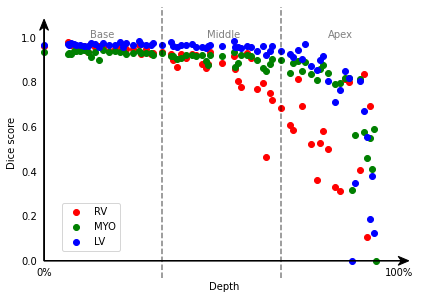

In [64]:
from evaluation.metrics import dice
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from glob import glob
import math
import numpy as np
import nibabel as nib
from tqdm import tqdm

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d

def arrowed_spines(fig, ax):

    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()

    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # removing the axis ticks
    #plt.xticks([]) # labels 
    #plt.yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    ax.spines["left"].set_position(("data", 0.0))
    ax.spines["bottom"].set_position(("data", 0.0))
    ax.set_xticks([0.0, 1.0])

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./20.*(ymax-ymin) 
    hl = 1./20.*(xmax-xmin)
    lw = 1. # axis line width
    ohg = 0.3 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    print(hw)
    print(hl)

    # draw x and y axis
    ax.arrow(0, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=0.04, head_length=0.03, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(0, 0, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=0.025, head_length=0.05, overhang = ohg, 
             length_includes_head= True, clip_on = False)
    
    ax.set_xlabel('Depth')
    ax.set_ylabel('Dice score')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

path_list = glob(r'Quorum_output_2\all_data\only_sfb\temp_allClasses\*.gz')
path_list_names = [x.split('\\')[-1][:13] for x in path_list]
path_list_gt = glob(r'custom_quorum\**\*_gt.nii.gz', recursive=True)
path_list_gt = [x for x in path_list_gt if x.split('\\')[-1][:13] in path_list_names]
assert len(path_list_gt) == len(path_list)

path_list = sorted(path_list, key=lambda x:x.split('\\')[-1])
path_list_gt = sorted(path_list_gt, key=lambda x:x.split('\\')[-1])

out_dict = {}
scores = []
for path, path_gt in tqdm(zip(path_list, path_list_gt), total=len(path_list)):
    data = nib.load(path)
    arr = data.get_fdata()

    data_gt = nib.load(path_gt)
    arr_gt = data_gt.get_fdata()

    assert arr.shape == arr_gt.shape
    patient_scores = []
    for i in range(arr.shape[-1]):
        #fig, ax = plt.subplots(1, 2)
        #ax[0].imshow(arr[:, :, i], cmap='gray')
        #ax[1].imshow(arr_gt[:, :, i], cmap='gray')
        #plt.show()
        #plt.waitforbuttonpress()
        #plt.close(fig)

        current_pred = arr[:, :, i]
        current_gt = arr_gt[:, :, i]

        #current_pred = arr
        #current_gt = arr_gt

        class_score = []
        for j in range(1, 4):
            current_class_pred = current_pred == j
            current_gt_pred = current_gt == j
            score = dice(current_class_pred, current_gt_pred)
            class_score.append(score)
        out_dict = update_dict(out_dict, key=i/arr.shape[-1], value=np.array(class_score))
        patient_scores.append(np.array(class_score))
    patient_class_score = np.stack(patient_scores, axis=0)
    patient_class_score = np.nanmean(patient_class_score, axis=0)
    scores.append(patient_class_score)
scores = np.stack(scores, 0)
scores = np.nanmean(scores, axis=0)

x = [[], [], []]
y = [[], [], []]
for key in out_dict.keys():
    class_dice = np.stack(out_dict[key], axis=0)
    class_dice = np.nanmean(class_dice, axis=0)
    for i in range(3):
        if not math.isnan(class_dice[i]):
            x[i].append(key)
            y[i].append(class_dice[i])

print(np.array(scores))

fig, ax = plt.subplots(1, 1)
ax.scatter(np.array(x[0]), np.array(y[0]), c='r', label='RV')
ax.scatter(np.array(x[1]), np.array(y[1]), c='g', label='MYO')
ax.scatter(np.array(x[2]), np.array(y[2]), c='b', label='LV')

ax.legend(loc=(0.1, 0.1))

#ax.set(xlabel='Depth as percent of volume', ylabel='Dice score')
arrowed_spines(fig, ax)
#fig.tight_layout()
fig.subplots_adjust(left=0.05, right=0.99, bottom=0.05, top=0.99)
plt.axvline(x=0.333333, c='black', linestyle='dashed', alpha=0.5)
plt.axvline(x=0.666666, c='black', linestyle='dashed', alpha=0.5)
plt.text(x=0.13, y=0.99999, s='Base', alpha=0.5)
plt.text(x=0.46, y=0.99999, s='Middle', alpha=0.5)
plt.text(x=0.80, y=0.99999, s='Apex', alpha=0.5)

plt.savefig("depth_dice.png", dpi=200)
plt.show()